In [2]:
import sys
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import scripts.statistics as stats
import scripts.get_namelist as nml

def which_tID(tvec,t):
    tID = np.argmin(np.abs(tvec-t))
    return tID

# Thickness and growth rates
def get_dtheta(directory,time):
    filename_prefix = directory+'/shearlayer_'
    tlist,dtheta,rate = growth_rates(filename_prefix)
    idx = np.argmin(abs(tlist-time))
    return dtheta[idx]

def growth_rates(filename_prefix):
    fname = filename_prefix+'growth.dat'
    dat = np.fromfile(fname,dtype=float, count=-1, sep=' ')
    n = np.size(dat)
    nstats=3
    dat = np.reshape(dat,[n/nstats,nstats])
    time = dat[:,0]
    dtheta = dat[:,1]
    rate = dat[:,2]
    return time,dtheta,rate

def which_tID(tvec,t):
    tID = np.argmin(np.abs(tvec-t))
    return tID

# get centerline from Reynolds stresses (vector)
def get_centerline(directory,y,time):
    nmodes = 10
    dat = np.fromfile( directory + 'shearlayer_Rij_'+str(tID)+'.dat',dtype=float, count=-1, sep=' ')
    n = np.size(dat)
    nstats=6
    dat = np.reshape(dat,[n/nstats,nstats]) 
    yc = 0
    for i in [0,1]:
        ic = np.argmax(smooth_modes(abs(dat[:,i]),nmodes))
        yc += y[ic]
    yc /= 2.    
    ic = np.argmin(abs(y-yc))
    return ic,y[ic]

def smooth_modes(f,nmodes):
    fhat = np.fft.fft(f)
    fhat[nmodes+1:-(nmodes+1):] = 0
    f = np.fft.ifft(fhat)
    return f

In [3]:
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr7/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr_7/1024x1448x512/'

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc04/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr7/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr_7/1024x1448x512/'

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc12/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc16/rr1/1024x1448x512/'
directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr7/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr_7/1024x1448x512/'

inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
y = np.linspace(-Ly/2.,Ly/2.,Ny)

flist = glob.glob(directory+"*Mt*")
flist.sort()
print([f.split('/')[-1] for f in flist])

# And read growth rates
tlist,dlist,rates = growth_rates(directory+'shearlayer_')

Params for this run:
	Mc = 2.0
	Re = 1000.0
	rr = 1.0
Params for this grid:
	N = 1024x1448x512
	L = 80.0x80.0x40.0
['shearlayer_Mt_0004.dat', 'shearlayer_Mt_0005.dat', 'shearlayer_Mt_0006.dat', 'shearlayer_Mt_0007.dat', 'shearlayer_Mt_0008.dat']


/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/1024x1448x512/
Mt mean, std: [0.363569241177, 0.0141598427806]


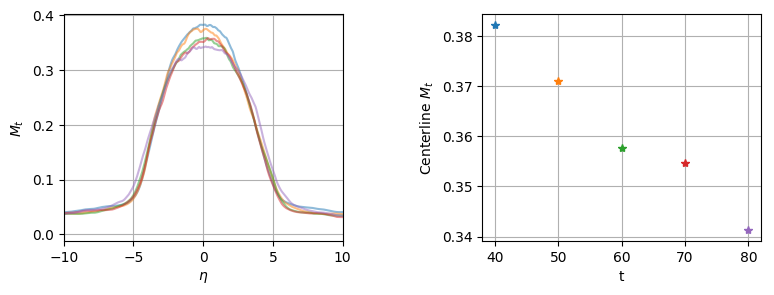

In [51]:
# vv correlation profiles
fig,ax = plt.subplots(1,2,figsize=(9,3), dpi=100)

flist_plot = flist[::]
Mts = np.zeros(len(flist_plot))

for count,fname in zip(range(len(flist_plot)),flist_plot):
    tID = fname.split('_')[-1]
    tID = tID.split('.dat')[0]
    time = nml.read_time(directory,tID)
    
    # Get eta
    dtheta = get_dtheta(directory,time)
    eta = y/dtheta
    
    # Get centerline
    ic,yc = get_centerline(directory,y,time)
    
    # Get turb Mach
    Mt = np.fromfile(fname,dtype=float, count=-1, sep=' ')
    ax[0].plot(eta, Mt, alpha=0.5,label='t=%d'%time)
   
    # Record for later
    ax[1].plot(time,Mt[ic],'*')
    Mts[count] = max(Mt)

# ax[0].legend()
ax[0].set_xlim([-10,10])
ax[0].set_xlabel(r'$\eta$')
ax[0].set_ylabel('$M_t$')
ax[1].set_xlabel(r'$\eta = y/\delta_\theta$')
ax[1].set_xlabel('t')
ax[1].set_ylabel('Centerline $M_t$')
for a in ax:
    a.grid(True)
plt.subplots_adjust(wspace = 0.5)   

idx = 0
print(directory)
print("Mt mean, std: [{}, {}]".format(np.mean(Mts[idx:]),np.std(Mts[idx:])))

# ax[0].legend(bbox_to_anchor=(0.8, 0.35))
plt.savefig(directory+'/img/Mt.png',dpi=200, bbox_inches='tight')